In [ ]:
import os
import subprocess
import itertools
import csv
from datetime import datetime
# === Session Details ===
# animal = "20241224PMCLE1"
# session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"

animal = "20241015PMCBE1"
session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope"

# === Parameter Grid Setup ===
wnd_size_vals    = [700, 1000, 1500]
stp_size_vals    = [700]  # Only one value
diff_thres_vals  = [3.5, 4.0, 5.0]
pnr_thresh_vals  = [1.1, "auto"]

# Determine max_wnd_vals based on session_dir.
# If "pmc" appears in the path, use 15; if "v1" appears, use 25; otherwise default to 25.
if "pmc" in session_dir.lower():
    max_wnd_vals = [15]
elif "v1" in session_dir.lower():
    max_wnd_vals = [25]
else:
    max_wnd_vals = [25]

# === Log File Setup ===
log_file = os.path.join(session_dir, "param_search_log.csv")
if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timestamp", "combination", "wnd_size", "stp_size", "max_wnd", "diff_thres", "pnr_thresh", "result_file"])

# === Complete Parameter File Template ===
param_template = r"""
import os
import numpy as np
import pathlib
# import datetime

param_seeds_init = {{
    'wnd_size': {wnd_size},  # window size
    'method': 'rolling',
    'stp_size': {stp_size},  # step size
    'max_wnd': {max_wnd},    # maximum window (set based on session type)
    'diff_thres': {diff_thres}  # difference threshold
}}

param_denoise = {{"method": "median", "ksize": 5}}
param_background_removal = {{"method": "tophat", "wnd": 15}}
noise_freq = 0.01
sparse_penal = 0.01

param_pnr_refine = {{"noise_freq": noise_freq, "thres": {pnr_thresh} }}  # try 1.1 or "auto"
param_ks_refine = {{"sig": 0.05}}
param_seeds_merge = {{"thres_dist": 10, "thres_corr": 0.8, "noise_freq": 0.01}}
param_initialize = {{"thres_corr": 0.8, "wnd": 10, "noise_freq": 0.01}}
param_init_merge = {{"thres_corr": 0.8}}

# CNMF Parameters#
param_get_noise = {{"noise_range": (0.01, 0.5)}}
param_first_spatial = {{
    "dl_wnd": 10,
    "sparse_penal": sparse_penal,  # remains at 0.01
    "size_thres": (25, None),
}}

param_first_merge = {{"thres_corr": 0.8}}

minian_path = "/home/lq53/mir_repos/minian/minian"

dpath = os.path.dirname(pathlib.Path(__file__).resolve())
minian_ds_path = os.path.join(dpath, "minian")
intpath = os.path.join(dpath, "minian_intermediate")
nc_file_name = os.path.join(dpath, "minian_dataset_{unique_id}.nc")

subset = dict(frame=slice(0, None))
subset_mc = None
interactive = True
output_size = 100
n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
param_save_minian = {{
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}}

param_load_videos = {{
    "pattern": "[0-9]+\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}}

subset_mc = None
param_estimate_motion = {{"dim": "frame"}}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath
"""

# === Grid Search Loop ===
for wnd_size, stp_size, max_wnd, diff_thres, pnr_thresh in itertools.product(
    wnd_size_vals, stp_size_vals, max_wnd_vals, diff_thres_vals, pnr_thresh_vals
):
    # Format the pnr_thresh value properly for Python syntax.
    if isinstance(pnr_thresh, str):
        pnr_thresh_str = f'"{pnr_thresh}"'
    else:
        pnr_thresh_str = pnr_thresh

    combination_str = f"wnd{wnd_size}_stp{stp_size}_max{max_wnd}_diff{diff_thres}_pnr{pnr_thresh}"
    print(f"Running combination: {combination_str}")
    
    # Generate parameter file content for the current combination.
    param_content = param_template.format(
        wnd_size=wnd_size,
        stp_size=stp_size,
        max_wnd=max_wnd,
        diff_thres=diff_thres,
        pnr_thresh=pnr_thresh_str,
        unique_id=combination_str
    )
    
    # Write the temporary parameter file in the session directory.
    param_file_path = os.path.join(session_dir, "minian_param_mir.py")
    with open(param_file_path, "w") as f:
        f.write(param_content)
    
    # Execute the main processing script in the session directory.
    result = subprocess.run(["python", "minian_mirpy_set.py"], cwd=session_dir, capture_output=True, text=True)
    print(result.stdout)
    if result.stderr:
        print("Errors:", result.stderr)
    
    # Determine the expected output file based on the unique identifier.
    output_nc = os.path.join(session_dir, f"minian_dataset_{combination_str}.nc")
    if not os.path.exists(output_nc):
        print(f"Warning: Output file not found for combination {combination_str}.")
        output_nc = "Not produced"
    
    # Log the parameter combination and result.
    timestamp = datetime.now().isoformat()
    with open(log_file, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([timestamp, combination_str, wnd_size, stp_size, max_wnd, diff_thres, pnr_thresh, output_nc])
    
    # Optional: Add a delay here if needed (e.g., time.sleep(10))


# # === Baseline Configuration ===
# baseline = {
#     "wnd_size": 1500,
#     "stp_size": 700,
#     "max_wnd": 25,
#     "diff_thres": 3.5,
#     "denoise_ksize": 5,
#     "noise_freq": 0.02,
#     "sparse_penal": 0.01,
#     "seeds_merge_thres": 5,  # fixed for PMC sessions
# }

# # === Create a list of parameter combinations (one-at-a-time variations) ===
# param_combinations = []

# # Add the baseline run
# param_combinations.append( ("baseline", baseline.copy()) )

# # Vary one parameter at a time (each combination overwrites one parameter)

# # Window Size: try 700 (instead of 1500)
# cfg = baseline.copy()
# cfg["wnd_size"] = 700
# param_combinations.append( ("wnd_size_700", cfg) )

# # Step Size: try 300 (instead of 700)
# cfg = baseline.copy()
# cfg["stp_size"] = 300
# param_combinations.append( ("stp_size_300", cfg) )

# # Max Window: try 15 (instead of 25)
# cfg = baseline.copy()
# cfg["max_wnd"] = 15
# param_combinations.append( ("max_wnd_15", cfg) )

# # Difference Threshold: try 4.0 (instead of 3.5)
# cfg = baseline.copy()
# cfg["diff_thres"] = 4.0
# param_combinations.append( ("diff_thres_4.0", cfg) )

# # Difference Threshold: try 5.0 (instead of 3.5)
# cfg = baseline.copy()
# cfg["diff_thres"] = 5.0
# param_combinations.append( ("diff_thres_5.0", cfg) )

# # Denoise Kernel Size: try 7 (instead of 5)
# cfg = baseline.copy()
# cfg["denoise_ksize"] = 7
# param_combinations.append( ("denoise_ksize_7", cfg) )

# # Noise Frequency: try 0.005 (instead of 0.02)
# cfg = baseline.copy()
# cfg["noise_freq"] = 0.005
# param_combinations.append( ("noise_freq_0.005", cfg) )

# # Noise Frequency: try 0.01 (instead of 0.02)
# cfg = baseline.copy()
# cfg["noise_freq"] = 0.01
# param_combinations.append( ("noise_freq_0.01", cfg) )

# # Sparse Penalization: try 0.005 (instead of 0.01)
# cfg = baseline.copy()
# cfg["sparse_penal"] = 0.005
# param_combinations.append( ("sparse_penal_0.005", cfg) )

# # Sparse Penalization: try 0.007 (instead of 0.01)
# cfg = baseline.copy()
# cfg["sparse_penal"] = 0.007
# param_combinations.append( ("sparse_penal_0.007", cfg) )

# # Sparse Penalization: try 0.02 (instead of 0.01)
# cfg = baseline.copy()
# cfg["sparse_penal"] = 0.02
# param_combinations.append( ("sparse_penal_0.02", cfg) )

# # Total runs = 12

# # === Log File Setup ===
# log_file = os.path.join(session_dir, "param_search_log.csv")
# if not os.path.exists(log_file):
#     with open(log_file, "w", newline="") as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(["timestamp", "combination", "wnd_size", "stp_size", "max_wnd",
#                          "diff_thres", "denoise_ksize", "noise_freq", "sparse_penal", "seeds_merge_thres", "result_file"])

# # === Full Parameter File Template ===
# # This template is your complete parameter file with placeholders for the parameters we want to vary.
# param_template = r"""
# import os
# import numpy as np
# import pathlib
# # import datetime

# # --- Seed Initialization Parameters ---
# param_seeds_init = {{
#     'wnd_size': {wnd_size},  # e.g., {wnd_size}
#     'method': 'rolling',
#     'stp_size': {stp_size},  # e.g., {stp_size}
#     'max_wnd': {max_wnd},    # e.g., {max_wnd}
#     'diff_thres': {diff_thres}  # e.g., {diff_thres}
# }}

# # --- Denoise and Background Parameters ---
# param_denoise = {{"method": "median", "ksize": {denoise_ksize}}}
# param_background_removal = {{"method": "tophat", "wnd": 15}}
# noise_freq = {noise_freq}
# sparse_penal = {sparse_penal}

# param_pnr_refine = {{"noise_freq": noise_freq, "thres": 1.1}}
# param_ks_refine = {{"sig": 0.05}}
# param_seeds_merge = {{ "thres_dist": {seeds_merge_thres}, "thres_corr": 0.8, "noise_freq": noise_freq }}
# param_initialize = {{ "thres_corr": 0.8, "wnd": 10, "noise_freq": noise_freq }}
# param_init_merge = {{ "thres_corr": 0.8 }}

# # --- CNMF Parameters ---
# param_get_noise = {{"noise_range": (noise_freq, 0.5)}}
# param_first_spatial = {{
#     "dl_wnd": 10,
#     "sparse_penal": sparse_penal,
#     "size_thres": (25, None),
# }}

# param_first_merge = {{ "thres_corr": 0.8 }}

# # --- Set up Basic Parameters ---
# minian_path = "/home/lq53/mir_repos/minian/minian"

# dpath = os.path.dirname(pathlib.Path(__file__).resolve())
# minian_ds_path = os.path.join(dpath, "minian")
# intpath = os.path.join(dpath, "minian_intermediate")
# nc_file_name = os.path.join(dpath, "minian_dataset_{unique_id}.nc")

# subset = dict(frame=slice(0, None))
# subset_mc = None
# interactive = True
# output_size = 100
# n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
# param_save_minian = {{
#     "dpath": minian_ds_path,
#     "meta_dict": dict(session=-1, animal=-2),
#     "overwrite": True,
# }}

# # --- Pre-processing Parameters ---
# param_load_videos = {{
#     "pattern": "[0-9]+\.avi$",
#     "dtype": np.uint8,
#     "downsample": dict(frame=1, height=1, width=1),
#     "downsample_strategy": "subset",
# }}

# # --- Motion Correction Parameters ---
# subset_mc = None
# param_estimate_motion = {{ "dim": "frame" }}

# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MINIAN_INTERMEDIATE"] = intpath
# """

# # === Loop over the parameter combinations ===
# for combo_name, cfg in param_combinations:
#     unique_id = combo_name  # use the combo name as unique identifier
#     print(f"Running combination: {unique_id}")
    
#     # Generate the parameter file content with current settings
#     param_content = param_template.format(
#         wnd_size = cfg["wnd_size"],
#         stp_size = cfg["stp_size"],
#         max_wnd = cfg["max_wnd"],
#         diff_thres = cfg["diff_thres"],
#         denoise_ksize = cfg["denoise_ksize"],
#         noise_freq = cfg["noise_freq"],
#         sparse_penal = cfg["sparse_penal"],
#         seeds_merge_thres = cfg["seeds_merge_thres"],
#         unique_id = unique_id
#     )
    
#     # Write the parameter file (minian_param_mir.py) in the session directory
#     param_file_path = os.path.join(session_dir, "minian_param_mir.py")
#     with open(param_file_path, "w") as f:
#         f.write(param_content)
    
#     # Run the main processing script (minian_mirpy_set.py)
#     result = subprocess.run(["python", "minian_mirpy_set.py"], cwd=session_dir, capture_output=True, text=True)
#     print(result.stdout)
#     if result.stderr:
#         print("Errors:", result.stderr)
    
#     # Expected output file name (nc file) with the unique identifier
#     output_nc = os.path.join(session_dir, f"minian_dataset_{unique_id}.nc")
#     if not os.path.exists(output_nc):
#         print(f"Warning: Output file not found for combination {unique_id}.")
#         output_nc = "Not produced"
    
#     # Log the run details
#     timestamp = datetime.now().isoformat()
#     with open(log_file, "a", newline="") as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow([timestamp, unique_id, cfg["wnd_size"], cfg["stp_size"], cfg["max_wnd"],
#                          cfg["diff_thres"], cfg["denoise_ksize"], cfg["noise_freq"], cfg["sparse_penal"],
#                          cfg["seeds_merge_thres"], output_nc])
    
#     # Optionally, add a delay between runs
#     # import time; time.sleep(10)


Running combination: wnd700_stp700_max15_diff3.5_pnr1.1


Found 4 output files.
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/minian_dataset_stp_size_300.nc


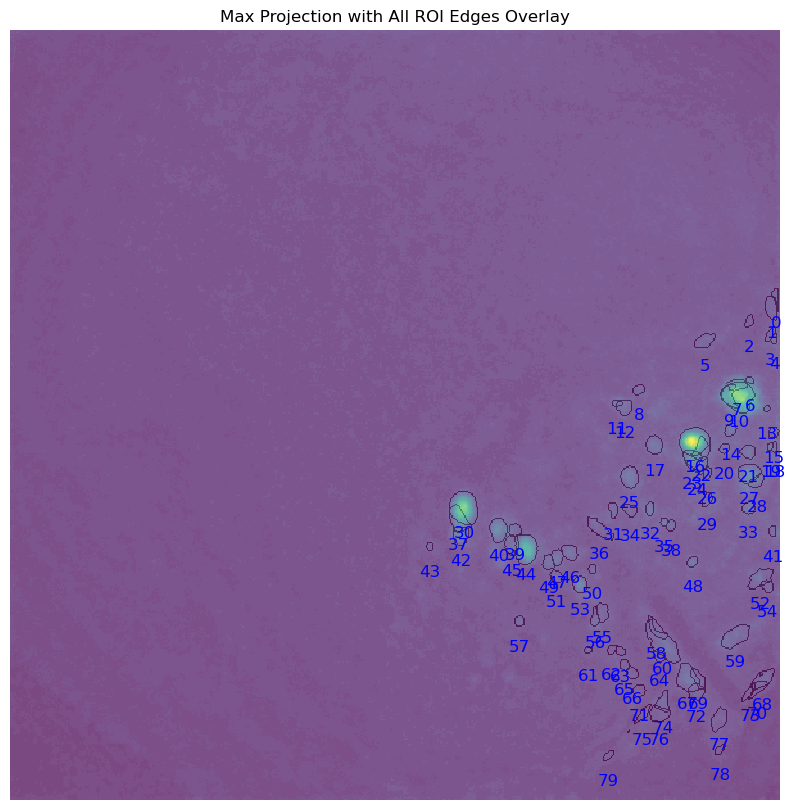

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/overlay_stp_size_300.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/minian_dataset_baseline.nc


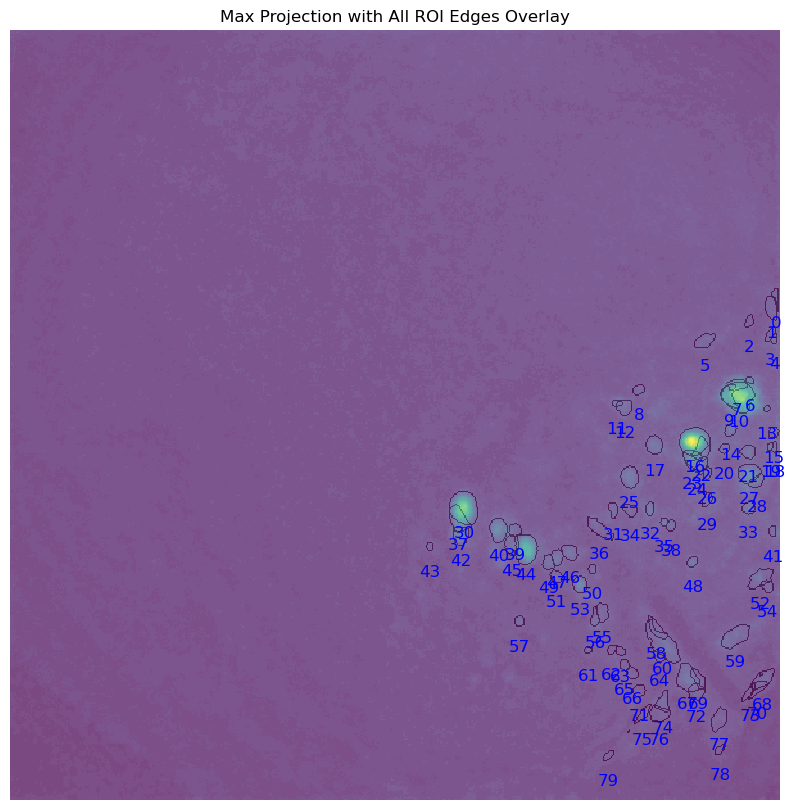

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/overlay_baseline.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/minian_dataset_max_wnd_15.nc


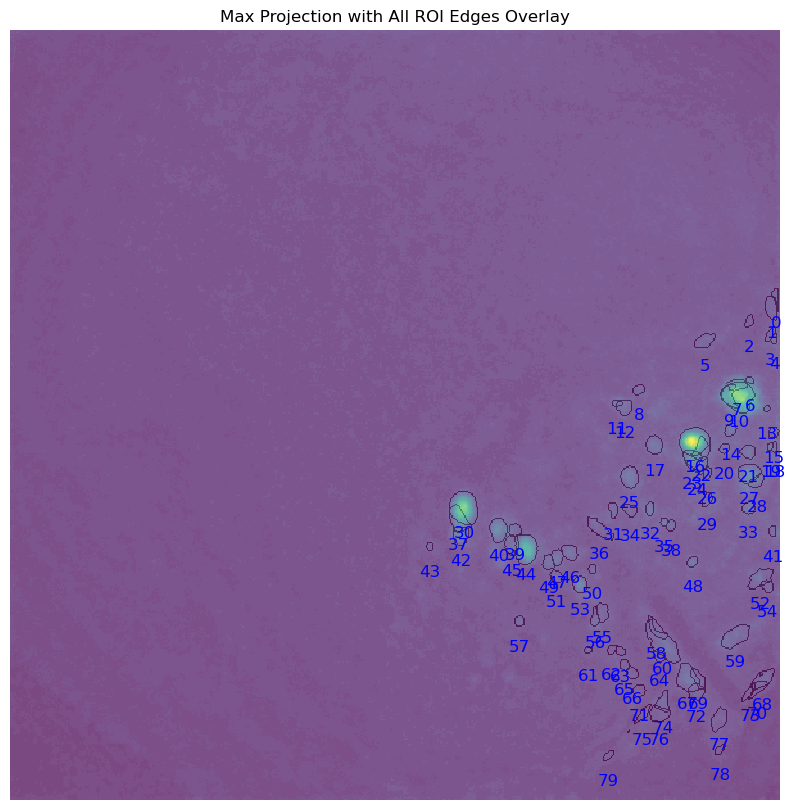

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/overlay_max_wnd_15.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/minian_dataset_wnd_size_700.nc


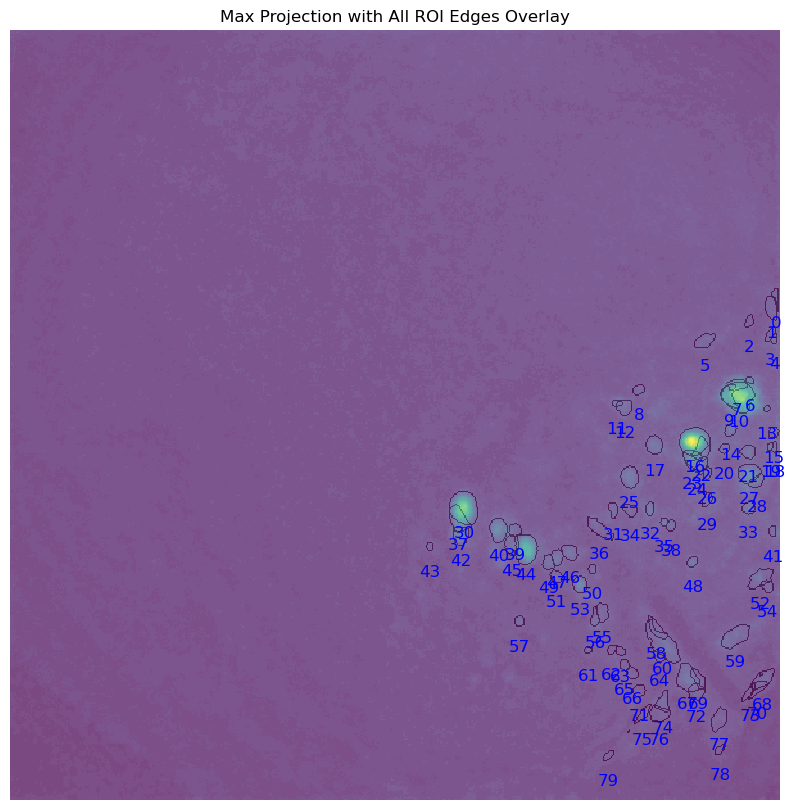

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_25_53/My_V4_Miniscope/overlay_wnd_size_700.png


In [2]:
import os
import sys
import glob
import shutil
import matplotlib.pyplot as plt

# Ensure the visualization utilities are in the path
sys.path.append(os.path.abspath('../../'))
from utlis.Ca_tools.roi_spike_vis_utlis import load_minian_data, calculate_dff, overlay_all_roi_edges

# --- Session Directory ---
# session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"

# --- Find All Output Files ---
# Looks for files like "minian_dataset_<unique_id>.nc"
nc_files = glob.glob(os.path.join(session_dir, "minian_dataset_*.nc"))

if not nc_files:
    print("No output files found in the session directory.")
else:
    print(f"Found {len(nc_files)} output files.")

# --- Loop Over Each Output File ---
for nc_file in nc_files:
    print("Processing:", nc_file)
    
    # Copy the specific output file to the expected filename 'minian_dataset.nc'
    temp_nc = os.path.join(session_dir, "minian_dataset.nc")
    shutil.copy2(nc_file, temp_nc)
    
    # Load data using the default mechanism of load_minian_data
    mini_timestamps = os.path.join(session_dir, 'timeStamps.csv')
    data, ts = load_minian_data(session_dir, mini_timestamps)
    
    # Calculate dF/F (if required for downstream visualization)
    dF_F = calculate_dff(data)
    
    # Extract the maximum projection for visualization
    max_proj = data['max_proj'].values
    
    # Create an overlay of all ROI edges on the maximum projection
    overlay_all_roi_edges(data, max_proj)
    
    # Set a title with the unique identifier extracted from the filename
    combination_id = os.path.basename(nc_file).replace("minian_dataset_", "").replace(".nc", "")
    plt.title("Overlay ROI Edges: " + combination_id)
    
    # Save the figure in the session directory using the unique identifier
    output_fig = os.path.join(session_dir, f"overlay_{combination_id}.png")
    plt.savefig(output_fig)
    plt.close()
    print(f"Saved overlay to: {output_fig}")
    
    # Remove the temporary file to avoid interference with the next iteration
    os.remove(temp_nc)
